### 5-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기



-  데이터셋은 네이버 영화의 리뷰의 한국어 텍스트의 감정 분석, Naver sentiment movie corpus.

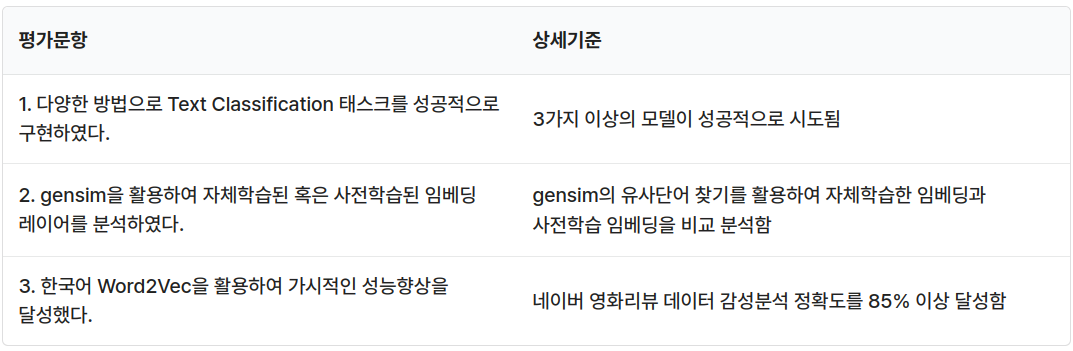







In [1]:
import pandas
import konlpy
import gensim
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### 1) 데이터 준비와 확인

In [2]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터 로더 구성

- 실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지   제공. 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일. 
  이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작. data_loader 안에서는 다음을 수행해야함.
  
  

  - 데이터의 중복 제거
  - NaN 결측치 제거
  - 한국어 토크나이저로 토큰화
  - 불용어(Stopwords) 제거
  - 사전word_to_index 구성
  - 텍스트 스트링을 사전 인덱스 스트링으로 변환
  - X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


- {숫자:단어} 의 딕셔너리 index_to_word 생성.

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

- 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수를 만든다. 



- 모든 문장은   < BOS > 로 시작. 



- get_encoded_sentence : 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
- get_encoded_sentences : 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
- get_decoded_sentence : 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
- get_decoded_sentences : 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
    

In [6]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index): # 여러개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode 
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word): # 숫자 벡터로 encode된 문장을 원래대로 decode. 
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])#[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word): # 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode. 
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포, 적절한 최대 문장 길이 지정, 



- 텍스트데이터 문장길이의 리스트를 생성



In [7]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens) # 최대 길이를 (평균 + 2*표준편차)로   
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함. 


- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가.




- post보다 pre가 효율이 더 좋아 문장 앞쪽에 pre padding 방식 적용.

In [10]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)  # (146182, 41)
print(X_test.shape)  # (49157, 41)

(146182, 41)
(49157, 41)


### 4) 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험

In [11]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기: 10000개 단어
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수 200. 

#### Model 1: RNN - LSTM

In [12]:
import tensorflow as tf 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   #  RNN인 LSTM 레이어를 사용, LSTM  벡터의 차원수 8. 
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


#### Model 2: 1-D CNN

In [14]:
model_1d_cnn = tf.keras.Sequential()
model_1d_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1d_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_1d_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_1d_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_1d_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1d_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

#### Model 3: GlobalMaxPooling1D() 

In [15]:
model_gmp1d = tf.keras.Sequential()
model_gmp1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp1d.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim.

model_gmp1d.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시



- train data에서 20%를 validation data로 떼내고 각각 data 크기 확인

In [16]:
x_val_len = int(len(X_train)*0.2)
y_val_len = int(len(y_train)*0.2)

x_val = X_train[:x_val_len]   
y_val = y_train[:y_val_len]

print('x_val : ', x_val.shape)  
print('y_val : ', y_val.shape)  

partial_x_train = X_train[x_val_len:]  
partial_y_train = y_train[y_val_len:]

print('x_train : ', partial_x_train.shape)  
print('y_train : ', partial_y_train.shape)  

x_val :  (29236, 41)
y_val :  (29236,)
x_train :  (116946, 41)
y_train :  (116946,)


- 적절한 epoch을 찾기위해 EarlyStopping 설정 필요

In [17]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

#### Model 1: RNN - LSTM

In [18]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
229/229 [==============================] - 25s 9ms/step - loss: 0.4368 - accuracy: 0.8112 - val_loss: 0.3572 - val_accuracy: 0.8458
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3217 - accuracy: 0.8658 - val_loss: 0.3396 - val_accuracy: 0.8525
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2902 - accuracy: 0.8794 - val_loss: 0.3384 - val_accuracy: 0.8546
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2646 - accuracy: 0.8921 - val_loss: 0.3505 - val_accuracy: 0.8527
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2417 - accuracy: 0.9016 - val_loss: 0.3568 - val_accuracy: 0.8533
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2213 - accuracy: 0.9104 - val_loss: 0.3829 - val_accuracy: 0.8518
Epoch 00006: early stopping


#### 모델 평가

In [19]:

results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_lstm)  # (0.3667, 0.8479)
     

1537/1537 - 3s - loss: 0.3888 - accuracy: 0.8482
[0.3887966275215149, 0.8482210040092468]


#### Model 2: 1-D CNN

In [20]:
model_1d_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20   

history_1d_cnn = model_1d_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])
     

Epoch 1/20
229/229 [==============================] - 6s 8ms/step - loss: 0.4578 - accuracy: 0.7726 - val_loss: 0.3411 - val_accuracy: 0.8523
Epoch 2/20
229/229 [==============================] - 1s 7ms/step - loss: 0.3013 - accuracy: 0.8733 - val_loss: 0.3237 - val_accuracy: 0.8595
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2377 - accuracy: 0.9059 - val_loss: 0.3327 - val_accuracy: 0.8595
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.1644 - accuracy: 0.9400 - val_loss: 0.3754 - val_accuracy: 0.8529
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.1027 - accuracy: 0.9657 - val_loss: 0.4580 - val_accuracy: 0.8471
Epoch 00005: early stopping


In [21]:
# 모델 평가
results_1d_cnn = model_1d_cnn.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_1d_cnn)  
     

1537/1537 - 3s - loss: 0.4757 - accuracy: 0.8420
[0.4756571650505066, 0.8420163989067078]


#### Model 3: GlobalMaxPooling1D() 

In [22]:
model_gmp1d.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_gmp1d = model_gmp1d.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
229/229 [==============================] - 2s 6ms/step - loss: 0.4734 - accuracy: 0.8058 - val_loss: 0.3485 - val_accuracy: 0.8474
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3149 - accuracy: 0.8670 - val_loss: 0.3337 - val_accuracy: 0.8536
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2679 - accuracy: 0.8906 - val_loss: 0.3383 - val_accuracy: 0.8563
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2274 - accuracy: 0.9114 - val_loss: 0.3528 - val_accuracy: 0.8568
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1870 - accuracy: 0.9306 - val_loss: 0.3737 - val_accuracy: 0.8540
Epoch 00005: early stopping


In [23]:
# 모델 평가
results_gmp1d = model_gmp1d.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_gmp1d)  

1537/1537 - 2s - loss: 0.3858 - accuracy: 0.8471
[0.38581764698028564, 0.8471428155899048]


### 6) Loss, Accuracy 그래프 시각화

#### Model 1: RNN - LSTM

In [24]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

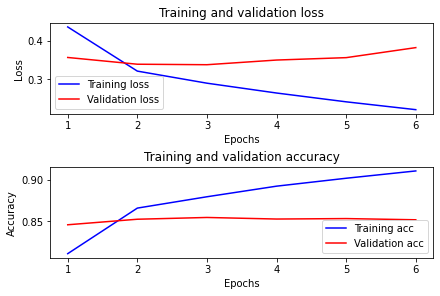

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

#### Model 2: 1-D CNN

In [27]:
history_dict = history_1d_cnn.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

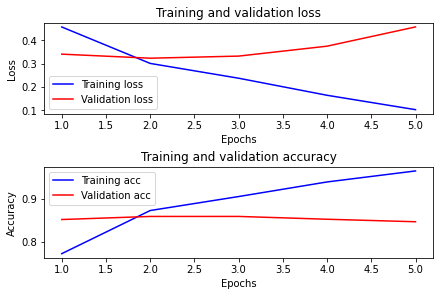

In [29]:
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

#### Model 3: GlobalMaxPooling1D() 

In [30]:
history_dict = history_gmp1d.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [31]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

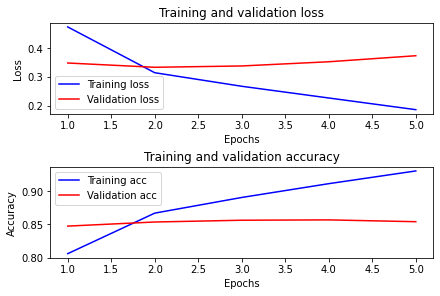

In [32]:
fig, axs = plt.subplots(2 ,1, constrained_layout=True)


axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()


axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

### 7) 학습된 Embedding 레이어 분석

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

#### Model 1: RNN - LSTM

In [34]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [36]:
# 학습한 Embedding 파라미터를 파일에 써서 저장.
import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['정서']
vector     

array([ 6.4672893e-03,  9.3183322e-03,  6.6101171e-02,  7.5939417e-02,
       -1.1427834e-02,  2.6505528e-02, -2.7644321e-02, -5.7827987e-02,
       -4.3878086e-02,  5.2269679e-02,  3.2569990e-02, -3.3397395e-02,
        1.0359144e-02, -1.4055096e-02, -2.3849992e-02, -1.9253356e-02,
       -5.5543993e-02, -4.5400362e-02,  2.0294059e-02, -4.8932379e-05,
       -9.8680503e-05, -4.9899708e-02,  1.8188380e-02,  1.9963428e-02,
       -2.7733102e-02,  1.6438613e-02,  2.4601261e-03, -4.1315194e-02,
        4.5575101e-02, -2.5282908e-02, -2.7739292e-02,  2.4121413e-02,
        1.5748698e-02, -6.5850206e-02,  3.3138276e-03, -4.6703860e-02,
        9.5287606e-02, -7.4188955e-02,  2.3077965e-02, -8.6545143e-03,
       -2.1522149e-02,  1.9413357e-03, -3.1044215e-02, -1.7913548e-02,
       -2.1907981e-02, -3.0665673e-02,  6.8489783e-03,  6.0142156e-02,
       -1.2885628e-02,  2.5465803e-02,  5.5310436e-02,  1.9626869e-02,
        5.9604734e-02, -3.9668258e-02, -1.9340675e-02, -2.3690809e-02,
      

In [38]:
word_vectors.similar_by_word("정서") 

[('챔프', 0.5665849447250366),
 ('이건', 0.5576685667037964),
 ('무료', 0.5475096702575684),
 ('이서진', 0.5451875925064087),
 ('복습', 0.5442549586296082),
 ('더니', 0.5399060249328613),
 ('바이올린', 0.5364243984222412),
 ('절반', 0.522381067276001),
 ('그냥저냥', 0.5200605392456055),
 ('우마서먼', 0.5137541890144348)]

In [39]:
word_vectors.similar_by_word("감동") 

[('입감', 0.824842095375061),
 ('best', 0.8225706219673157),
 ('명작', 0.816413402557373),
 ('최고', 0.8081545233726501),
 ('♥', 0.8036238551139832),
 ('짱', 0.8032909631729126),
 ('어땠', 0.8031696081161499),
 ('어울려요', 0.8016461133956909),
 ('재미있', 0.8009287714958191),
 ('꾀', 0.8006016612052917)]

In [40]:
word_vectors.similar_by_word("서사") 

[('보입니다', 0.662287712097168),
 ('자나', 0.662163496017456),
 ('딘', 0.6397033333778381),
 ('선가', 0.638416051864624),
 ('패션', 0.6325415968894958),
 ('케이', 0.6277185678482056),
 ('느', 0.6265426278114319),
 ('꾹', 0.623562216758728),
 ('어울린다', 0.6217981576919556),
 ('나온다면', 0.6176552176475525)]

#### Model 2: 1-D CNN

In [41]:
embedding_layer = model_1d_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [42]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록. 
vectors = model_1d_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [43]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['정서']
vector

array([ 0.00086819,  0.02264196,  0.04440936, -0.08966922, -0.06798402,
       -0.02119788, -0.00443461, -0.01056472, -0.04367696,  0.09439669,
       -0.1291273 ,  0.0205626 ,  0.13033949,  0.00859621, -0.00341052,
        0.11912586,  0.05109723,  0.03489996, -0.03523805,  0.03916074,
        0.06790844, -0.08213098, -0.02713236,  0.04072502,  0.07907552,
       -0.14822865, -0.1061647 ,  0.06768077, -0.08741817,  0.06483731,
        0.05253043, -0.02669583,  0.04547052, -0.00020355,  0.149214  ,
       -0.02072765,  0.01974501, -0.08115357, -0.06441163, -0.0371466 ,
        0.05428847, -0.00278979,  0.15356202, -0.05040924, -0.05082864,
       -0.02213469, -0.03751593,  0.02962669, -0.02789075,  0.00518201,
       -0.03001316, -0.02951956,  0.09252577, -0.02435257,  0.09652343,
       -0.07885843, -0.00765461, -0.15917124,  0.03727636,  0.10991594,
       -0.08001076,  0.00964085,  0.01619163,  0.078705  ,  0.09520572,
       -0.00814748, -0.00507784, -0.03391928, -0.04612686,  0.11

In [44]:
word_vectors.similar_by_word("정서") 

[('보트', 0.5155208110809326),
 ('했으나', 0.5067936778068542),
 ('주연', 0.5000755786895752),
 ('하아', 0.4910947382450104),
 ('전화', 0.4880342483520508),
 ('약', 0.47709858417510986),
 ('3', 0.4690958261489868),
 ('동성애자', 0.4544174373149872),
 ('챔프', 0.4505496323108673),
 ('거짓말', 0.44466862082481384)]

In [45]:
word_vectors.similar_by_word("감동") 

[('통해서', 0.6048161387443542),
 ('새록새록', 0.6009418964385986),
 ('뒤돌아보', 0.598369836807251),
 ('되돌아보', 0.5967826843261719),
 ('눈물나', 0.5966566801071167),
 ('데요', 0.5916422009468079),
 ('맴도', 0.5872620940208435),
 ('훈', 0.5845539569854736),
 ('첫째', 0.5830137729644775),
 ('very', 0.5825607180595398)]

In [46]:
word_vectors.similar_by_word("서사") 

[('설득', 0.36930522322654724),
 ('예정', 0.35310015082359314),
 ('ㅜㅡ', 0.342803955078125),
 ('장인', 0.33943310379981995),
 ('에반', 0.3373841941356659),
 ('생각날', 0.33640363812446594),
 ('어다', 0.3337249755859375),
 ('극한', 0.3330630958080292),
 ('잔혹', 0.3245558440685272),
 ('웨스', 0.32394304871559143)]

#### Model 3: GlobalMaxPooling1D() 

In [47]:
embedding_layer = model_gmp1d.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    

(10000, 200)


In [48]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model_gmp1d.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [49]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['정서']
vector

array([-3.23670357e-02, -4.93946783e-02,  2.27576066e-02, -4.93700020e-02,
       -4.44405563e-02, -2.85883527e-02, -4.41900156e-02, -3.17790247e-02,
       -5.55153266e-02,  5.67514338e-02, -4.50168028e-02,  1.29894502e-02,
       -3.62263024e-02, -5.57969660e-02,  3.85110565e-02, -4.82609868e-02,
       -2.36284975e-02,  8.73736888e-02, -9.09981877e-03, -4.33509722e-02,
       -1.12419412e-03, -5.30052334e-02, -1.54186599e-02,  8.25385377e-02,
       -3.75477672e-02, -2.64639501e-02, -3.29637080e-02,  3.28369588e-02,
       -4.98855524e-02, -1.35568269e-02, -4.60514203e-02, -3.30956727e-02,
       -1.15798796e-02, -6.32228777e-02, -5.17350212e-02, -6.06086431e-03,
        7.80104473e-02, -4.44624461e-02,  2.89024077e-02, -2.97202077e-02,
        3.96900214e-02, -2.85955425e-02, -5.65416031e-02,  5.48478924e-02,
        3.80024910e-02, -4.29758802e-02,  3.76113728e-02, -3.76584902e-02,
        3.55455698e-03,  6.96472405e-03, -1.70899497e-04, -3.52053046e-02,
        3.47529314e-02,  

In [50]:
word_vectors.similar_by_word("정서") 

[('ㅉㅉ', 0.44879090785980225),
 ('버려', 0.42055651545524597),
 ('...............', 0.4167497456073761),
 ('억지', 0.4095802307128906),
 ('꼴', 0.409506618976593),
 ('짱나', 0.4087807834148407),
 ('재미없', 0.40541523694992065),
 ('어설픈', 0.4035071134567261),
 ('소품', 0.4015251398086548),
 ('프로', 0.39445051550865173)]

In [51]:
word_vectors.similar_by_word("감동") 

[('마저', 0.46003419160842896),
 ('개인', 0.44142812490463257),
 ('고', 0.44106829166412354),
 ('아', 0.43914881348609924),
 ('게', 0.4331740736961365),
 ('어', 0.4298872649669647),
 ('너무', 0.42861929535865784),
 ('반전', 0.42798009514808655),
 ('움', 0.4209502339363098),
 ('임', 0.41967377066612244)]

In [52]:
word_vectors.similar_by_word("서사") 

[('빤', 0.37696290016174316),
 ('분장', 0.33539366722106934),
 ('식상', 0.33365243673324585),
 ('변신', 0.3145952522754669),
 ('부실', 0.311029851436615),
 ('한방', 0.3098423182964325),
 ('수박', 0.29715415835380554),
 ('사기', 0.2941647171974182),
 ('재미없', 0.2886853814125061),
 ('낚시', 0.28852081298828125)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models
https://radimrehurek.com/gensim/models/keyedvectors.html

 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]



#### 그나마 Validation Accuracy가 높은 RNN으로 시도



- 완성된 임베딩 매트릭스의 크기 확인

In [53]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors


word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'

word2vec = gensim.models.Word2Vec.load(word2vec_path)

print(word2vec.wv.vectors.shape)     

(302960, 100)


In [54]:
vector = word2vec.wv.most_similar("정서")  
vector 

[('감정', 0.8119149208068848),
 ('태도', 0.7313265204429626),
 ('심리', 0.7248765826225281),
 ('냉소', 0.7103310227394104),
 ('정신', 0.7058107256889343),
 ('욕구', 0.6870599389076233),
 ('육체', 0.6832504272460938),
 ('이상주의', 0.6756746172904968),
 ('고뇌', 0.6723883748054504),
 ('이기주의', 0.6719932556152344)]

In [55]:
word2vec.wv.most_similar("감동") 

[('감격', 0.8046045899391174),
 ('감탄', 0.7326707243919373),
 ('매혹', 0.7267226576805115),
 ('매력', 0.7088802456855774),
 ('감명', 0.7069407105445862),
 ('웃음', 0.7015025615692139),
 ('열정', 0.6936471462249756),
 ('칭찬', 0.6831857562065125),
 ('실망', 0.6779423952102661),
 ('슬픔', 0.6770600080490112)]

In [56]:
word2vec.wv.most_similar("서사") 

[('사실주의', 0.7060965895652771),
 ('우화', 0.6998763084411621),
 ('서정시', 0.678611695766449),
 ('문체', 0.6593903303146362),
 ('회화', 0.6591224074363708),
 ('멜로드라마', 0.6586183309555054),
 ('자연주의', 0.6532244086265564),
 ('미학', 0.640590488910675),
 ('세계사', 0.6395928859710693),
 ('통속', 0.6387115716934204)]

In [57]:
vocab_size = len(word_to_index)    # 어휘 사전 10,000개의 단어
word_vector_dim = 100  

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [58]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(256))  
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()
Model: "sequential_4"

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,367,633
Trainable params: 1,367,633
Non-trainable params: 0
_________________________________________________________________


- 학습 시킴

In [59]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
229/229 [==============================] - 7s 25ms/step - loss: 0.4720 - accuracy: 0.7715 - val_loss: 0.3865 - val_accuracy: 0.8274
Epoch 2/20
229/229 [==============================] - 5s 23ms/step - loss: 0.3506 - accuracy: 0.8459 - val_loss: 0.3423 - val_accuracy: 0.8493
Epoch 3/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2965 - accuracy: 0.8741 - val_loss: 0.3239 - val_accuracy: 0.8585
Epoch 4/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2564 - accuracy: 0.8939 - val_loss: 0.3141 - val_accuracy: 0.8648
Epoch 5/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2243 - accuracy: 0.9091 - val_loss: 0.3247 - val_accuracy: 0.8657
Epoch 6/20
229/229 [==============================] - 5s 23ms/step - loss: 0.1919 - accuracy: 0.9241 - val_loss: 0.3418 - val_accuracy: 0.8595
Epoch 7/20
229/229 [==============================] - 5s 23ms/step - loss: 0.1584 - accuracy: 0.9386 - val_loss: 0.3630 - val_accuracy: 0.8621

In [60]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results) 

1537/1537 - 4s - loss: 0.3667 - accuracy: 0.8594
[0.36674171686172485, 0.8593689799308777]


#### Patience를 5에서 3으로 바꿨더니 성능이 올라가 accuracy가 0.859이 나왔음.

In [62]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [63]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

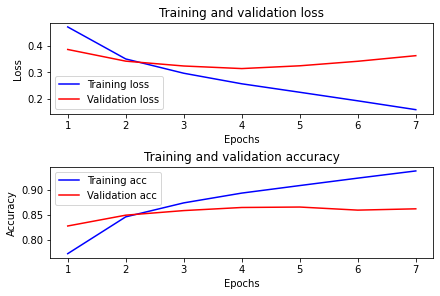

In [68]:
fig, axs = plt.subplots(2 ,1, constrained_layout=True) # 그림판

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

### Reference




- https://wikidocs.net/80437 자연어 처리를 위한 1D CNN(1D Convolutional Neural Networks)




- https://chat.openai.com/ word_vector_dim = 4 




- https://wikidocs.net/50739 gensim
  https://radimrehurek.com/gensim/models/keyedvectors.html gensim




- https://ratsgo.github.io/natural%20language%20processing/2019/09/12/embedding/ 한국어 임베딩 서문



- https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models Word2Vec Model




- https://tempdev.tistory.com/35  Subplot들의 간격 조정

### 결론 및 회고 

- 반복되는 내용들이 있지만 이번 프로젝트는 내용이 많아 전체적으로 파악한게 아직도 선명치 못해 마감까지 제출은 하고 찬찬 다시보고 정리한거 보완할 필요가 있음.
 
    
    
- 5)-1 AttributeError: 'list' object has no attribute 'shape'이런 오류는 Numpy 객체를 변환해야함. -> 위에서 변수명을 통일시켜 해결.
    
    
 
    
- epoch돌릴때 patience를 5로 설정했더니 2개 모델이 0.85이하로 떨어져 patience = 3 하니  accuracy가 개선됐음. 
    
    
    
    
- 마지막 fig, axs = plt.subplots(2 ,1, constrained_layout=True) 이코드 빠져 오류 해결하는데 시간 걸림.    
    
    
#### [해결하지 못한 의문점들]

    



- 적절한 validation 데이터는 train의 몇 %가 적절한지? Q 무작위 시행착오로만  알수있는지 ? Justin처럼 식으로 설계해서 최적화하는 방법은? 